# Melbourne House Prices Prediction using XGBoost with hyperparameter tuning and 10 fold cross-validation
> ## By itsdylantan

In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


## Reading and setting up data


### Code below to set up data is referenced/based on Alexis Cook's notebook

In [39]:
import pandas as pd
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id')
X_test_full = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', index_col='Id')

###  EDA: Visualization to get an understanding of the data

>### Shape of training set

In [40]:
X.shape

(1460, 80)

> ### First few rows of of training set

In [41]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Preprocessing the dataset: Imputation and One-hot encoding

In [42]:
# Drop NA
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Split data 80% 20% train test
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Getting the numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]


my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encoding
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

## Model 1 Build and predictions
> ### Model build using Pipelines

In [43]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline1 = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', XGBRegressor(random_state= 2001))
])
# Using XGBoost Ensemble Method
my_pipeline1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=2001, reg_alpha=0,
                    

> ### Model predictions and validation


In [44]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

predictions_1 = my_pipeline1.predict(X_valid)
mae_1 = mean_absolute_error(y_valid, predictions_1)
print("Model 1: Mean absolute error = ", mae_1)

Model 1: Mean absolute error =  17620.33422517123


## Model 2 (With parameter tuning)
> ### Increasing n_estimators and reducing learning_rate (overfitting prevention)

In [45]:
my_pipeline2 = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', XGBRegressor(n_estimators=100, learning_rate = 0.05, random_state= 2001))])
# Using XGBoost Ensemble Method
my_pipeline2.fit(X_train, y_train)

predictions_2 = my_pipeline2.predict(X_valid)
mae_2 = mean_absolute_error(y_valid, predictions_2)
print("Model 2: Mean absolute error = ", mae_2)

Model 2: Mean absolute error =  17543.96264982877


## Model 1 vs Model 2
**Model 1:** Mean absolute error =  17620.33422517123

**Model 2:** Mean absolute error =  17543.9626498288

**Model 2** performs better than **Model 1** when using the test set and keeping n_estimators the same but changing the learning rate.

## Finding the optimal n_estimators value.
> ### Creating a function that gets average MAE for varying n_estimators that uses 10-fold cross validation

In [46]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    """Returns average MAE using 10 fold CV.
    
    Arguments:
    n_estimators -- the number of trees
    """
    my_pipeline = Pipeline(steps = [("preprocessor", SimpleImputer()),
                                    ("model", XGBRegressor(n_estimators = n_estimators, random_state = 2001))])
   
    scores_list = -1 * cross_val_score(my_pipeline, X, y,
                              cv=10,
                              scoring='neg_mean_absolute_error')
    return scores_list.mean()

> ### For number of trees. = {50, 100, 150, ..., 300, 350, 400}.

In [47]:
results = {}
for i in range(1,9):
    results[50*i] = get_score(50*i)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 

> ### Using Matplotlib to view MAE scores for varying n_estimators

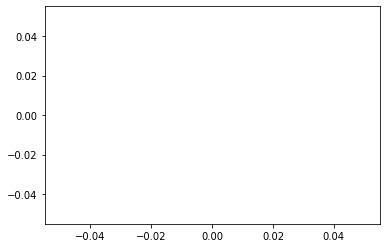

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

## Fix this, not sure why not showing up anymore. May have some columns with errors.

## Competition Submission to Kaggle

In [49]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': predictions_2})
output.to_csv('submission.csv', index=False)

ValueError: All arrays must be of the same length